# Relaxation Methods

In this notebook, we will illustrate the use of relaxation for solving time-independent boundary value problems, using electrostatics as an example. Relaxation is an iterative technique for solving linear systems of equations, in which an initial guess at a solution is supplied, and allowed to "relax" via iteration towards the final solution.

Here we study three different methods :
* Jacobi
* Gauss-Seidel
* Successive Over Relaxation (SOR)


# The Laplace Equation

Consider the Laplace equation $(\nabla^2V = 0)$ in one dimension. The grid of nodes in this case can be taken as a series of $n$ equally spaced points $x_i$ with a spacing $\Delta x = h$. The Taylor expansion of $V$ around the point $x_i$ is :

$$ V(x) = V(x_i) + h \frac{dV(x_i)}{dx} + h^2 \frac{d^2V(x_i)}{2 dx^2} + ...$$

so adding the values at $\Delta x = \pm h$ (i.e. at $x_{n \pm 1}$) gives :

$$ V(x_{i−1}) + V(x_{i+1}) = 2V(x_i) + h^2 \frac{d^2V(x_i)}{dx^2} $$

which can be rearranged to give Equation 1 :

$$ \frac{d^2V(x_i)}{dx^2} = \frac{V(x_{i−1}) + V(x_{i+1}) − 2V(x_i)}{h^2}  $$

This is the standard finite difference representation for the second derivative.

Generalising this equation to 2D, and rearranging, gives Equation 2, that can be used to iterate the value at each node:

$$ V(x_i,y_j)= \frac{1}{4} (V(x_{i−1},y_j)+V(x_{i+1},y_j)+V(x_i,y_{j−1})+V(x_i,y_{j+1}))$$

Hence each node is simply the average of its four closest neighbours.

## Jacobi Method

First we consider the Jacobi method. Here we store two copies of the grid, and for each iteration we compute a new value for each node based on the previous iteration.

First we need some code to store the grid values and boundary conditions. We will want to re-use this code for the Gauss-Seidel and SOR algorithms. This is a good example of where use of a class is appropriate.  The class contains internal data :
* `v0` and `v1` are the two copies of the grid.
* `isDirichlet` is a grid of boolean values which can be set if a node is a Dirichlet boundary node.
* `dirichletValue` stores the value of Dirichlet nodes

We then define functions which should be self-explanatory, to setup the grid given a size $N_x, N_y$ in `setupGrid()`, define the boundary nodes in `setDirichletNode()`, and initialise the grid to random values in `initRandom()`.  We also include a class function (method) `fde()` that implements the Laplace finite difference equation.

In [2]:
import numpy as np

class LaplaceSolverGrid:
    """Grids for solving the Laplace equation with Dirichlet boundary conditions"""
    
    def setup(self, n_x, n_y):
        """Initialise internal variables"""
        # two copies of the grid for Jacobi method
        self.v0 = np.zeros((n_x, n_y))
        self.v1 = np.zeros((n_x, n_y))
        
        # array to set which nodes are fixed (Dirichlet boundaries) 
        self.isDirichlet = np.zeros((n_x, n_y), dtype=bool)
        
        # actual values of Dicirhlet nodes
        self.dirichletValue = np.zeros((n_x, n_y))
                
    def setDirichletNode(self, i, j, v):
        """Set a given node to a boundary value"""
        self.isDirichlet[i,j] = True
        self.dirichletValue[i,j] = v

    def initRandom(self, vmin, vmax):
        """Initialise each node to a random value in given range"""
        # we use np.where() to ensure Dirichlet nodes are set to their
        # correct boundary values
        rnd = vmin + (vmax-vmin)*np.random.rand(self.v0.shape[0], self.v0.shape[1])
        self.v0 = np.where(self.isDirichlet, self.dirichletValue, rnd)
        self.v1 = np.where(self.isDirichlet, self.dirichletValue, rnd)
    
    def fde(self, i, j):
        """Apply the finite difference equation (non-vectorised)"""
        # nodes not on the grid edge
        return 0.25*(self.v0[i-1,j]+self.v0[i+1,j]+self.v0[i,j-1]+self.v0[i,j+1])
    
    def info(self):
        """Print some info about the grids"""
        print("V0 grid min {}".format(np.min(self.v0)))
        print("V0 grid max {}".format(np.max(self.v0)))
        print("V1 grid min {}".format(np.min(self.v1)))
        print("V1 grid max {}".format(np.max(self.v1)))

    def plots(self):
        """Make some plots of the internal variables"""
        
        # plot isDirichlet grid
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(self.isDirichlet, cmap='jet')
        axes[0].set_title("isDirichlet")

        # plot dirichletValue grid
        axes[1].imshow(self.dirichletValue, cmap='jet')
        axes[1].set_title("dirichletValue")

        # plot v0 grid
        im = axes[2].imshow(self.v0, cmap='jet')
        axes[2].set_title("Initial values")

        plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
        plt.show()

First we want to check the setup and initialisation code behaves as expected.

In [3]:
import matplotlib.pyplot as plt

# create a 50x50 grid
grid = LaplaceSolverGrid()
grid.setup(50,50)

# set boundary nodes to constant value
for i in range(50):
    grid.setDirichletNode(i, 0, 10.)
    grid.setDirichletNode(i, 49, 10.)
    grid.setDirichletNode(0, i, 10.)
    grid.setDirichletNode(49, i, 10.)

grid.initRandom(0., 5.)

grid.plots()

<Figure size 2000x500 with 4 Axes>

Now we are ready to implement the Jacboi method itself. The function takes a `LaplaceSolverGrid` object as its first argument, a convergence condition `atol` (which will halt iteration when the maximum change in any node is less than the specified value), as well as min and max numbers of iterations. The results will be available in the grid object, but the function also returns the number of iterations taken, as well as the resulting maximum difference, so we can study its performance.

In [4]:
def runJacobi(grid, atol, nmin, nmax):
    """Implement Jacobi relaxation"""
    
    # this loop just keeps track of the iteration number
    for k in range(nmax) :

        # double loop to scan over the grid
        for i in range(grid.v0.shape[0]):
            for j in range(grid.v0.shape[1]):

                # do not update Dirichlet nodes
                if grid.isDirichlet[i,j]:
                    grid.v1[i,j] = grid.dirichletValue[i,j]
                    
                # but set new version (v1) of remaining nodes to theFDE value
                else:
                    grid.v1[i,j] = grid.fde(i,j)
                
        # test for convergence
        if k>nmin and np.allclose(grid.v0, grid.v1, atol=atol):
            return k, np.max(np.abs(grid.v1-grid.v0))
        
        # update "old" version (v0) of the grid
        # note the use of np.copy() - using = would make grid.v0 a reference to grid.v1
        grid.v0 = np.copy(grid.v1)
        
    return k, np.max(np.abs(grid.v1-grid.v0))

We can test this using the grid we have already created.  First we can use the `nmin`, `nmax` arguments to fix the number of iterations and look at the impact qualitatively.

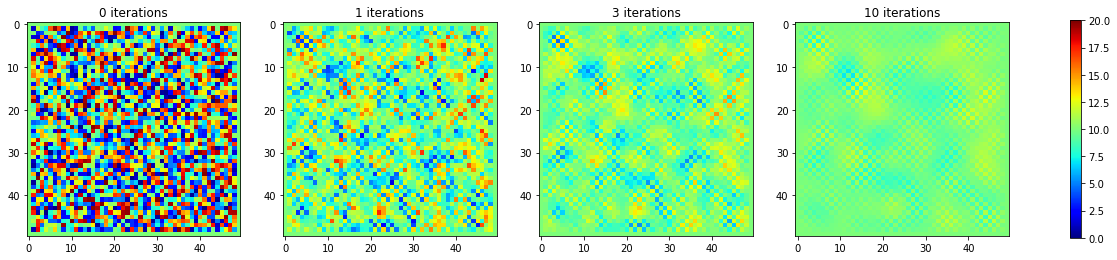

In [5]:
grid.initRandom(0, 20.)

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

im = axes[0].imshow(grid.v0, vmin=0, vmax=20, cmap='jet')
axes[0].set_title("0 iterations")

runJacobi(grid, 1e-12, 1, 1)
axes[1].imshow(grid.v0, vmin=0, vmax=20, cmap='jet')
axes[1].set_title("1 iterations")

runJacobi(grid, 1e-12, 2, 2)
axes[2].imshow(grid.v0, vmin=0, vmax=20, cmap='jet')
axes[2].set_title("3 iterations")

runJacobi(grid, 1e-12, 7, 7)
axes[3].imshow(grid.v0, vmin=0, vmax=20, cmap='jet')
axes[3].set_title("10 iterations")

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

Hopefully it's clear why relaxation methods are sometimes referred to as 'smoothing' methods. The process of averaging over neighbouring nodes smooths the initially random grid. In this case, since we set Dirichlet nodes at the boundary of the grid, with constant value, the value of all nodes trend towards this value.

Now we can study the convergence time and error more systematically. Here we will iterate over a range of tolerances and study the number of iterations taken to converge, as well as the maximum node error with respect to the known solution.

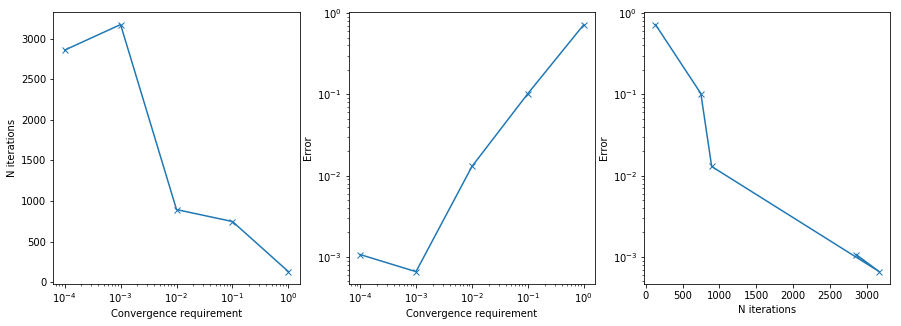

In [6]:
tols = np.logspace(0, -4, 5)
ks_1 = []
errs_1 = []

# loop over a range of tolerances
for tol in tols:
    grid.initRandom(0, 20.)
    k, d = runJacobi(grid, tol, 1, 10000)
    
    # store number of iterations
    ks_1.append(k)
    
    # store max difference wrt known solution
    egrid = grid.v0 - 10.*np.ones(grid.v0.shape)
    errs_1.append(np.max(np.abs(egrid)))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot tolerance vs N iterations
axes[0].plot(tols, ks_1, marker='x')
axes[0].set_xscale('log')
axes[0].set_xlabel("Convergence requirement")
axes[0].set_ylabel("N iterations")

# plot tolerance vs error
axes[1].plot(tols, errs_1, marker='x')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Convergence requirement')
axes[1].set_ylabel('Error')

# plot N iterations vs error
axes[2].plot(ks_1, errs_1, marker='x')
axes[2].set_yscale('log')
axes[2].set_xlabel('N iterations')
axes[2].set_ylabel('Error')

plt.show()

## Gauss-Seidel Iteration

We will re-use the `LaplaceSolverGrid` class, but this time we will not use the `v1` data member. Instead we update the `v0` grid 'in place', based on the finite difference equation. Note that since we are not using two copies of the grid, we have to re-implement the convergence condition to find the maximum change in a nodes value on each iteration over the grid.



In [38]:
def runGaussSeidel(grid, atol, nmin, nmax):
    """Implement Gauss-Seidel relaxation"""
    
    # this loop just keeps track of the iteration number
    for k in range(nmax) :

        dmax = 0.
        
        # double loop to scan over the grid
        for i in range(grid.v0.shape[0]):
            for j in range(grid.v0.shape[1]):

                # do not update Dirichlet nodes
                if grid.isDirichlet[i,j]:
                    grid.v0[i,j] = grid.dirichletValue[i,j]
                    
                # but set new version (v1) of remaining nodes to the FDE value
                else:
                    old = grid.v0[i,j]
                    new = grid.fde(i,j)
                    d = new-old
                    if abs(d)>dmax:
                        dmax=abs(d)
                    grid.v0[i,j] = new

        # test for convergence
        if k>nmin and dmax<atol:
            return k, dmax

    return k, dmax


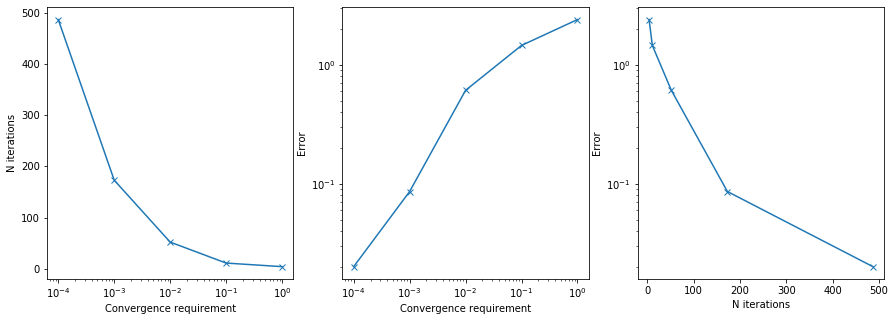

In [39]:
ks_2 = []
errs_2 = []

# loop over a range of tolerances
for tol in tols:
    grid.initRandom(0, 20.)
    k, d = runGaussSeidel(grid, tol, 1, 10000)
    
    # store number of iterations
    ks_2.append(k)
    
    # store max difference wrt known solution
    egrid = grid.v0 - 10.*np.ones(grid.v0.shape)
    errs_2.append(np.max(np.abs(egrid)))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot tolerance vs N iterations
axes[0].plot(tols, ks_2, marker='x')
axes[0].set_xscale('log')
axes[0].set_xlabel("Convergence requirement")
axes[0].set_ylabel("N iterations")

# plot tolerance vs error
axes[1].plot(tols, errs_2, marker='x')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Convergence requirement')
axes[1].set_ylabel('Error')

# plot N iterations vs error
axes[2].plot(ks_2, errs_2, marker='x')
axes[2].set_yscale('log')
axes[2].set_xlabel('N iterations')
axes[2].set_ylabel('Error')

plt.show()

## Successive Over Relaxation

Finally, we can implement the SOR method.  This is identical to Gauss-Seidel, but now we over-correct each node by a factor $\omega$.

In [40]:
def runSOR(grid, omega, atol, nmin, nmax):
    """Implement successive-over-relaxation"""
    
    # this loop just keeps track of the iteration number
    for k in range(nmax) :

        dmax = 0.
        
        # double loop to scan over the grid
        for i in range(grid.v0.shape[0]):
            for j in range(grid.v0.shape[1]):

                # do not update Dirichlet nodes
                if grid.isDirichlet[i,j]:
                    grid.v0[i,j] = grid.dirichletValue[i,j]
                    
                # but set new version (v1) of remaining nodes to the FDE value
                else:
                    old = grid.v0[i,j]
                    new = grid.fde(i,j)
                    d = new-old
                    if abs(d) > dmax:
                        dmax=abs(d)
                    grid.v0[i,j] = old+omega*d

        # test for convergence
        if k>nmin and dmax<atol:
            return k, dmax

    return k, dmax

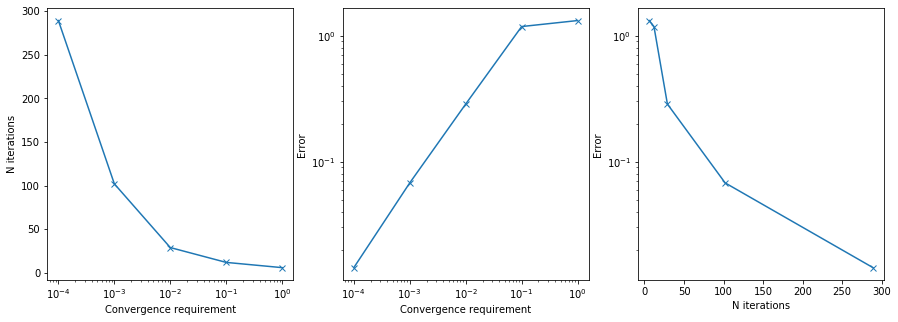

In [49]:
ks_3 = []
errs_3 = []

# loop over a range of tolerances
for tol in tols:
    grid.initRandom(0, 20.)
    k, d = runSOR(grid, 1.4, tol, 1, 10000)
    
    # store number of iterations
    ks_3.append(k)
    
    # store max difference wrt known solution
    egrid = grid.v0 - 10.*np.ones(grid.v0.shape)
    errs_3.append(np.max(np.abs(egrid)))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot tolerance vs N iterations
axes[0].plot(tols, ks_3, marker='x')
axes[0].set_xscale('log')
axes[0].set_xlabel("Convergence requirement")
axes[0].set_ylabel("N iterations")

# plot tolerance vs error
axes[1].plot(tols, errs_3, marker='x')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Convergence requirement')
axes[1].set_ylabel('Error')

# plot N iterations vs error
axes[2].plot(ks_3, errs_3, marker='x')
axes[2].set_yscale('log')
axes[2].set_xlabel('N iterations')
axes[2].set_ylabel('Error')

plt.show()

Finally, we can compare the convergence rate of each method.  Here we plot the error with respect to the known solution, against the number of iterations required to reach convergence.  This circumvents any dependence on subtle differences between the convergence criteria for each method.

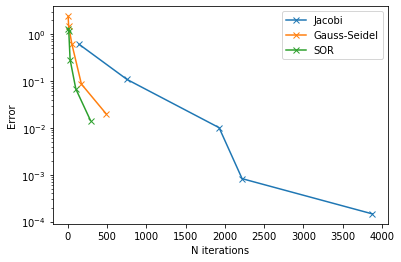

In [50]:
plt.plot(ks_1, errs_1, marker='x', label='Jacobi')
plt.plot(ks_2, errs_2, marker='x', label='Gauss-Seidel')
plt.plot(ks_3, errs_3, marker='x', label='SOR')
plt.yscale('log')
plt.xlabel('N iterations')
plt.ylabel('Error')
plt.legend()
plt.show()

# Example - Parallel Plate Capacitor

Now we consider a practical example - calculating the potential and electric field within and around a parallel plate capacitor comprising a pair of plates of length a, separation d.

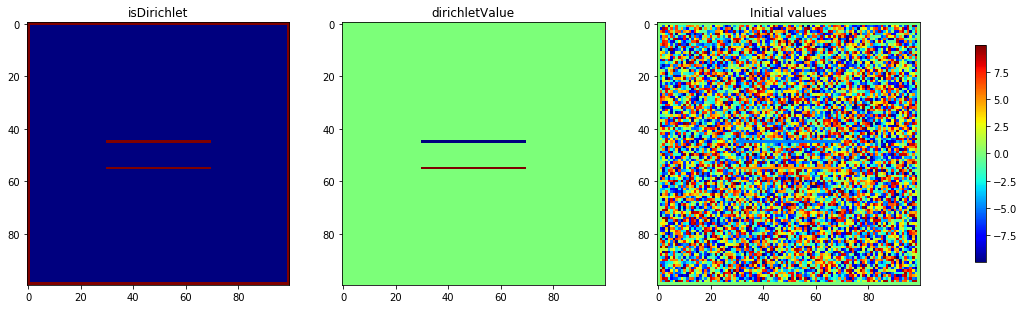

In [56]:
import math

# some parameters
n = 100 # grid size
a = 40  # capacitor plate length
d = 10  # capacitor plate separation
v = 5   # capacitor plate voltage

# setup the grid
grid = LaplaceSolverGrid()
grid.setup(n,n)

# set the edges of the grid to zero
for i in range(n):
    grid.setDirichletNode(i, 0, 0.)
    grid.setDirichletNode(i, n-1, 0.)
    grid.setDirichletNode(0, i, 0.)
    grid.setDirichletNode(n-1, i, 0.)

# now set capacitor plate boundary conditions
ymid = math.floor(n/2)
ytop = ymid+math.floor(d/2)
ybot = ymid-math.floor(d/2)
xleft = ymid-math.floor(a/2)
for i in range(a):
    grid.setDirichletNode(ytop, xleft+i, v)
    grid.setDirichletNode(ybot, xleft+i, -1*v)

# initialize grid
grid.initRandom(-10., 10.)
grid.plots()

# run the SOR relaxation
k, d = runSOR(grid, 1.1, 1e-3, 10, 10000)

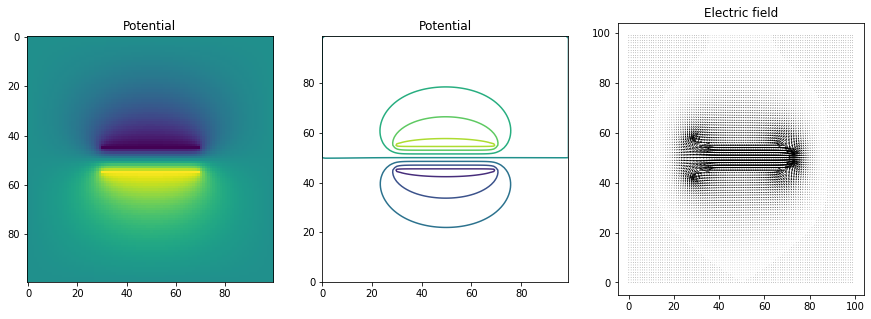

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot the potential
axes[0].imshow(grid.v0)
axes[0].set_title('Potential')

# plot potential contours
axes[1].contour(grid.v0)
axes[1].set_aspect('equal', 'box')
axes[1].set_title('Potential')

# calculate and plot electric field
dx, dy = np.gradient(grid.v0)
axes[2].quiver(dx, dy)
axes[2].set_title('Electric field')
plt.show()

The field is clearly uniform between the plates, as expected. We can also see the non-zero field outside the plates, due to the finite size of the plates.  (Recall that, due to Gauss' law, the field is zero outside the plates in the infinite plate approximation).